In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications import VGG19,ResNet152
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Input,Resizing,Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Model
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nibabel as nib
import os
import re
import xml.etree.ElementTree as ET
from tqdm import tqdm
from scipy.stats import entropy
from skimage.exposure import histogram
import cv2

2025-06-24 12:23:50.633627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750767830.802614      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750767830.853661      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv("/kaggle/input/adni-1-5t/adni_labels.csv")

In [ ]:
df

In [23]:
df.describe()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Age,Downloaded
count,2294.000000,0.0
mean,75.638622,NaN
std,6.662227,NaN
min,55.000000,NaN
25%,72.000000,NaN
50%,76.000000,NaN
75%,80.000000,NaN
max,91.000000,NaN


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2294 entries, 0 to 2293
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Image Data ID  2294 non-null   object 
 1   Subject        2294 non-null   object 
 2   Group          2294 non-null   object 
 3   Sex            2294 non-null   object 
 4   Age            2294 non-null   int64  
 5   Visit          2294 non-null   object 
 6   Modality       2294 non-null   object 
 7   Description    2294 non-null   object 
 8   Type           2294 non-null   object 
 9   Acq Date       2294 non-null   object 
 10  Format         2294 non-null   object 
 11  Downloaded     0 non-null      float64
dtypes: float64(1), int64(1), object(10)
memory usage: 215.2+ KB


In [3]:
folder_path = '/kaggle/input/adni-1-5t/ADNI1_Complete 1Yr 1.5T/ADNI'
paths = []
print(paths)

[]


In [4]:
folder_2 = '/kaggle/input/adni-1-5t/ADNI1_Complete_1Yr_1.5T_metadata/ADNI'

In [5]:
for root_dir, dirs, files in tqdm(os.walk(folder_path), desc="Scanning files"):
    for file in files:
        if file.endswith(".nii") or file.endswith(".nii.gz"):
            final_path = os.path.join(root_dir, file)
            rel_path = os.path.relpath(final_path, folder_path)

            # Extract subject and image ID using regex
            match = re.search(r'_S(\d+)_I(\d+)', file)
            if match:
                s_num = match.group(1)
                i_num = match.group(2)
                new_filename = f"S{s_num}I{i_num}.xml"

                nii_dir = os.path.dirname(rel_path)
                xml_path = os.path.join(folder_2, nii_dir, new_filename)

                if os.path.exists(xml_path):
                    try:
                        tree = ET.parse(xml_path)
                        xml_root = tree.getroot()
                        id = xml_root[3].attrib.get('uid', None)

                        if id:
                            row = df[df['Image Data ID'].astype(str).str.strip() == str(id).strip()]
                            if not row.empty:
                                label = row.iloc[0, 2]
                                paths.append((label, final_path))
                            else:
                                print(f"[!] ID {id} not found in DataFrame")
                        else:
                            print(f"[!] UID not found in XML: {xml_path}")
                    except Exception as e:
                        print(f"[!] Failed to parse XML: {xml_path} — {e}")
                else:
                    print(f"[!] XML file missing: {xml_path}")
            else:
                print(f"[!] Failed to extract subject/image ID from: {file}")

Scanning files: 1690it [00:12, 130.51it/s]


In [7]:
len(paths)

459

In [29]:
paths[0]

('MCI',
 '/kaggle/input/adni-1-5t/ADNI1_Complete 1Yr 1.5T/ADNI/133_S_0913/MPR__GradWarp__B1_Correction__N3__Scaled_2/2007-07-18_15_09_17.0/I119636/ADNI_133_S_0913_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081008095615528_S35319_I119636.nii')

In [30]:
scan_1 = nib.load(paths[0][1])
data_1 = scan_1.get_fdata()
header = scan_1.header
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='>'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'133_S_0913'
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 166   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.         0.94131845 0.9375     1.2036749  1.         1.
 1.         1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 2907
glmin           : 0
descrip         : b'MPR; GradWarp; B1 Correction; N3; Scaled_2'
aux_file        : b'none'
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.70710677
quatern_c       : -3.3128877e-10
quatern_

In [31]:
print(data_1.shape)
print(data_1[0,:,:])

(256, 256, 166)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [32]:
data_1.shape[0]

256

In [6]:
filtered_paths = []
filtered_paths

[]

In [7]:
for path in paths:
    if path[0] in ('AD', 'CN'):
        filtered_paths.append(path)

In [8]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

In [9]:
def center_crop(image, crop_size=128):
    h, w = image.shape
    if h < crop_size or w < crop_size:
        return None
    top = (h - crop_size) // 2
    left = (w - crop_size) // 2
    return image[top:top+crop_size, left:left+crop_size]

def image_entropy(img):
    hist, _ = histogram(img)
    hist = hist / np.sum(hist)
    return entropy(hist, base=2)

In [10]:
X = []
y = []

In [11]:
for path in tqdm(filtered_paths):
    scan = nib.load(path[1])
    data = scan.get_fdata()
    label = 0 if path[0] == 'AD' else 1

    slice_info = []

    for axis in range(3):
        for i in range(data.shape[axis]):
            if axis == 0:
                slice_ = data[i, :, :]
            elif axis == 1:
                slice_ = data[:, i, :]
            else:
                slice_ = data[:, :, i]

            cropped = center_crop(slice_)
            if cropped is None:
                continue

            cropped_uint8 = cv2.normalize(cropped, None, 0, 255, cv2.NORM_MINMAX)
            cropped_uint8 = cropped_uint8.astype(np.uint8)

            # Apply CLAHE
            clahe_applied = clahe.apply(cropped_uint8)
            
            # Convert back to float32 normalized [0, 1] for entropy calculation
            norm = clahe_applied.astype(np.float32) / 255.0

            ent = image_entropy(norm)
            slice_info.append((ent, norm))

    # Sort by entropy, keep top 100
    slice_info.sort(reverse=True, key=lambda x: x[0])
    top_slices = slice_info[:110]

    for _, slice_img in top_slices:
        slice_rgb = np.stack([slice_img]*3, axis=-1)  # (128, 128, 3)
        X.append(slice_rgb)
        y.append(label)

100%|██████████| 234/234 [06:11<00:00,  1.59s/it]


In [12]:
X = np.array(X, dtype='float32')
y = np.array(y, dtype='int')

In [40]:
X.shape

(25740, 128, 128, 3)

In [41]:
y.shape

(25740,)

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [43]:
input_tensor = Input(shape=(128,128,3))

In [44]:
vgg19 = VGG19(include_top=False,weights='imagenet',input_shape=(128,128,3))

I0000 00:00:1750760802.895331      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750760802.895994      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [45]:
for layer in vgg19.layers:
  layer.trainable = False

In [46]:
x = vgg19(input_tensor)
x = Flatten()(x)
x = Dense(4096,activation='relu')(x)
x = Dense(4096,activation='relu')(x)
x = Dense(4096,activation='relu')(x)
output_tensor = Dense(1,activation='sigmoid')(x)

In [47]:
vgg19_model = Model(inputs=input_tensor,outputs=output_tensor)
vgg19_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      33,558,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,149,633 (332.45 MB)

 Trainable params: 67,125,249 (256.06 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [48]:
optimizer = Adam(
    learning_rate=1e-6
)
'''
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=7
)
'''

"\nearly_stop = tf.keras.callbacks.EarlyStopping(\n    monitor='val_accuracy',\n    patience=7\n)\n"

In [49]:
vgg19_model.compile(optimizer='Adam',loss=BinaryCrossentropy(),metrics=['accuracy'])

In [50]:
vgg19_history = vgg19_model.fit(x=X_train,y=y_train,batch_size=64,epochs=35,validation_split=0.1)

Epoch 1/35


I0000 00:00:1750760822.784111     101 service.cc:148] XLA service 0x7e8c100129b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750760822.786214     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750760822.786244     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750760823.366625     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/290 ━━━━━━━━━━━━━━━━━━━━ 1:09:26 14s/step - accuracy: 0.6094 - loss: 0.6754

I0000 00:00:1750760834.075970     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


290/290 ━━━━━━━━━━━━━━━━━━━━ 79s 223ms/step - accuracy: 0.5867 - loss: 1.5605 - val_accuracy: 0.6718 - val_loss: 0.5836
Epoch 2/35
290/290 ━━━━━━━━━━━━━━━━━━━━ 60s 208ms/step - accuracy: 0.7239 - loss: 0.5365 - val_accuracy: 0.7830 - val_loss: 0.4644
Epoch 3/35
290/290 ━━━━━━━━━━━━━━━━━━━━ 59s 204ms/step - accuracy: 0.7866 - loss: 0.4556 - val_accuracy: 0.7408 - val_loss: 0.4742
Epoch 4/35
290/290 ━━━━━━━━━━━━━━━━━━━━ 59s 204ms/step - accuracy: 0.8339 - loss: 0.3681 - val_accuracy: 0.8146 - val_loss: 0.3849
Epoch 5/35
290/290 ━━━━━━━━━━━━━━━━━━━━ 60s 206ms/step - accuracy: 0.8746 - loss: 0.2953 - val_accuracy: 0.8316 - val_loss: 0.3956
Epoch 6/35
290/290 ━━━━━━━━━━━━━━━━━━━━ 60s 206ms/step - accuracy: 0.8906 - loss: 0.2672 - val_accuracy: 0.8311 - val_loss: 0.3907
Epoch 7/35
290/290 ━━━━━━━━━━━━━━━━━━━━ 60s 206ms/step - accuracy: 0.9139 - loss: 0.2133 - val_accuracy: 0.8752 - val_loss: 0.2935
Epoch 8/35
290/290 ━━━━━━━━━━━━━━━━━━━━ 59s 205ms/step - accuracy: 0.9260 - loss: 0.1853 - val

In [51]:
vgg19_evaluation = vgg19_model.evaluate(x=X_test,y=y_test)

161/161 ━━━━━━━━━━━━━━━━━━━━ 30s 137ms/step - accuracy: 0.9252 - loss: 0.3694


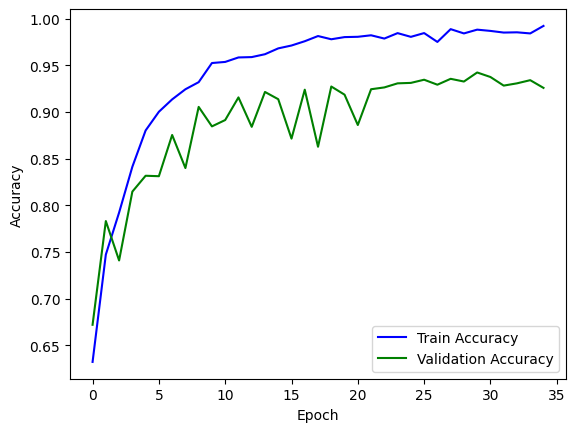

In [52]:
plt.plot(vgg19_history.history['accuracy'],color='Blue',label='Train Accuracy')
plt.plot(vgg19_history.history['val_accuracy'],color='Green',label='Validation Accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [14]:
input_tensor = Input(shape=(128,128,3))

In [15]:
resbase = ResNet152(include_top=False,weights='imagenet',input_shape=(128,128,3))

I0000 00:00:1750768233.653070      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750768233.653789      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [16]:
for layer in resbase.layers[:-5]:
    layer.trainable = False

In [17]:
x = resbase(input_tensor)
x = Flatten()(x)
x = Dense(4096,activation='relu')(x)
x = Dense(4096,activation='relu')(x)
x = Dense(4096,activation='relu')(x)
output_tensor = Dense(1,activation='sigmoid')(x)

In [18]:
res_model = Model(inputs=input_tensor,outputs=output_tensor)
res_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152 (Functional)               │ (None, 4, 4, 2048)          │      58,370,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │     134,221,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 226,159,489 (862.73 MB)

 Trainable params: 168,843,265 (644.09 MB)

 Non-trainable params: 57,316,224 (218.64 MB)

In [19]:
Adam_optimizer = Adam(
    learning_rate=1e-6
)

In [20]:
res_model.compile(optimizer=Adam_optimizer,loss=BinaryCrossentropy(),metrics=['accuracy'])

In [ ]:
histrory = res_model.fit(x=X_train,y=y_train,batch_size=64,epochs=175,validation_split=0.1)

Epoch 1/175


I0000 00:00:1750768282.046812     103 service.cc:148] XLA service 0x7e0a440e0030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750768282.048050     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750768282.048077     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750768286.224294     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750768292.727191     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


290/290 ━━━━━━━━━━━━━━━━━━━━ 125s 297ms/step - accuracy: 0.6133 - loss: 0.6569 - val_accuracy: 0.6165 - val_loss: 0.6642
Epoch 2/175
290/290 ━━━━━━━━━━━━━━━━━━━━ 67s 231ms/step - accuracy: 0.6618 - loss: 0.6175 - val_accuracy: 0.6670 - val_loss: 0.6078
Epoch 3/175
290/290 ━━━━━━━━━━━━━━━━━━━━ 66s 228ms/step - accuracy: 0.6937 - loss: 0.5897 - val_accuracy: 0.6937 - val_loss: 0.5840
Epoch 4/175
290/290 ━━━━━━━━━━━━━━━━━━━━ 66s 227ms/step - accuracy: 0.7164 - loss: 0.5656 - val_accuracy: 0.7136 - val_loss: 0.5653
Epoch 5/175
290/290 ━━━━━━━━━━━━━━━━━━━━ 66s 229ms/step - accuracy: 0.7373 - loss: 0.5435 - val_accuracy: 0.7189 - val_loss: 0.5480
Epoch 6/175
290/290 ━━━━━━━━━━━━━━━━━━━━ 66s 227ms/step - accuracy: 0.7930 - loss: 0.4723 - val_accuracy: 0.7592 - val_loss: 0.5059
Epoch 9/175
 73/290 ━━━━━━━━━━━━━━━━━━━━ 45s 209ms/step - accuracy: 0.8082 - loss: 0.4488

In [12]:
class EntropySliceGenerator(Sequence):
    def __init__(self, filtered_paths, batch_size=32, crop_size=128, top_k=68, shuffle=True):
        self.paths = filtered_paths      # List of (label, path)
        self.batch_size = batch_size
        self.crop_size = crop_size
        self.top_k = top_k
        self.shuffle = shuffle
        self.slice_cache = []
        self.label_cache = []
        self.file_idx = 0
        self.slice_idx = 0
        self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.paths)

    def __len__(self):
        # Approximate number of batches (depends on slices/file)
        return int(len(self.paths) * self.top_k / self.batch_size)

    def _load_next_file(self):
        if self.file_idx >= len(self.paths):
            self.file_idx = 0

        label_str, path = self.paths[self.file_idx]
        label = 0 if label_str == 'AD' else 1
        self.file_idx += 1

        scan = nib.load(path).get_fdata()
        slice_info = []

        for axis in range(3):
            for i in range(scan.shape[axis]):
                if axis == 0:
                    slice_ = scan[i, :, :]
                elif axis == 1:
                    slice_ = scan[:, i, :]
                else:
                    slice_ = scan[:, :, i]

                cropped = center_crop(slice_, self.crop_size)
                if cropped is None:
                    continue

                normed = cv2.normalize(cropped, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
                clahe_applied = clahe.apply(normed)
                normalized = clahe_applied.astype(np.float32) / 255.0

                ent = image_entropy(normalized)
                slice_info.append((ent, normalized))

        # Sort and select top-k
        slice_info.sort(reverse=True, key=lambda x: x[0])
        selected = slice_info[:self.top_k]

        self.slice_cache = [np.stack([s]*3, axis=-1) for _, s in selected]  # (128,128,3)
        self.label_cache = [label] * len(self.slice_cache)
        self.slice_idx = 0

    def __getitem__(self, idx):
        X, y = [], []

        while len(X) < self.batch_size:
            if self.slice_idx >= len(self.slice_cache):
                self._load_next_file()

            X.append(self.slice_cache[self.slice_idx])
            y.append(self.label_cache[self.slice_idx])
            self.slice_idx += 1

        return np.array(X, dtype='float32'), np.array(y, dtype='int32')

In [13]:
train_val_paths, test_paths = train_test_split(
    filtered_paths, 
    test_size=0.2, 
    random_state=42, 
    stratify=[x[0] for x in filtered_paths]
)

In [14]:
train_paths, val_paths = train_test_split(
    train_val_paths, 
    test_size=0.1, 
    random_state=42, 
    stratify=[x[0] for x in train_val_paths]
)

In [15]:
train_gen = EntropySliceGenerator(train_paths, batch_size=32, shuffle=True)
val_gen   = EntropySliceGenerator(val_paths, batch_size=32, shuffle=False)
test_gen  = EntropySliceGenerator(test_paths, batch_size=32, shuffle=False)

In [16]:
vgginstance = VGG19(include_top = False,weights='imagenet',input_shape = (128,128,3))
for layer in vgginstance.layers:
    layer.trainable = False
input_tensor = Input(shape=(128,128,3))
x = vgginstance(input_tensor)
x = Flatten()(x)
x = Dense(4096,activation='relu')(x)
x = Dense(4096,activation='relu')(x)
x = Dense(4096,activation='relu')(x)
output_tensor = Dense(1,activation='sigmoid')(x)
model = Model(inputs=input_tensor,outputs=output_tensor)
model.compile(optimizer='Adam',loss=BinaryCrossentropy(),metrics=['accuracy'])

I0000 00:00:1750765824.952242      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750765824.952906      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(train_gen,validation_data=val_gen,epochs=35)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35


I0000 00:00:1750765844.868125     102 service.cc:148] XLA service 0x7ff39000fad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750765844.869060     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750765844.869079     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750765845.354137     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/357 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.2969 - loss: 0.5815   

I0000 00:00:1750765851.045851     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


357/357 ━━━━━━━━━━━━━━━━━━━━ 295s 799ms/step - accuracy: 0.6302 - loss: 32.0805 - val_accuracy: 0.5844 - val_loss: 0.6799
Epoch 2/35
357/357 ━━━━━━━━━━━━━━━━━━━━ 223s 623ms/step - accuracy: 0.5941 - loss: 0.9369 - val_accuracy: 0.5844 - val_loss: 0.6858
Epoch 3/35
357/357 ━━━━━━━━━━━━━━━━━━━━ 219s 611ms/step - accuracy: 0.6206 - loss: 0.6872 - val_accuracy: 0.5844 - val_loss: 0.6836
Epoch 4/35
 27/357 ━━━━━━━━━━━━━━━━━━━━ 2:57 537ms/step - accuracy: 0.5558 - loss: 0.6865